In [1]:
from helpers import *
import numpy as np
import itertools
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from tqdm import tqdm
from datetime import datetime
from itertools import product
pd.set_option('display.max_columns', None)

In [2]:
save_dir = ''
file_names = glob.glob(os.path.join(save_dir, f'QCEH_data/TCV_DATAno*.parquet'))

List of dataframes (one discharge per each element of the list)

In [3]:
df_list = [pd.read_parquet(x) for x in file_names]
len(df_list)

60

# Initial Data Analysis
For this project we are only focusing on the machine inputs provided in the data.

In [4]:
GENERAL_INPUTS = ["shotnumber", "time"]
MACHINE_INPUTS = ["isbaffled", "ip","b0","nel","ptot","pdiv","q95","betan","kappa","deltaavg","deltaupp",
                  "deltalow","gapin","gapout","zmag","rmag","rmin","lpar_ot","zeff"]
LABEL = ["LHD_label"]
INPUTS = GENERAL_INPUTS + MACHINE_INPUTS + LABEL
len(INPUTS)

22

In [5]:
data = pd.concat(df_list, ignore_index=True)[INPUTS]
print(data.shape)
data.head(1)

(624858, 22)


,shotnumber,time,isbaffled,ip,b0,nel,ptot,pdiv,q95,betan,kappa,deltaavg,deltaupp,deltalow,gapin,gapout,zmag,rmag,rmin,lpar_ot,zeff,LHD_label
0,78600.0,0.65,1.0,-168210.37515,-1.442735,3.756246e+19,175726.540319,0.01331,4.560044,0.732083,1.51264,0.515621,0.34732,0.683923,0.027576,0.034128,-0.019449,0.890963,0.224565,15.855245,1.555953,1.0


Before getting deep into the patterns and correlations of our data, we must understand it better.

As such we would like to know if the features are categorical or numerical, what are the ranges of values etc.

### Are the features numerical or categorical?

In [6]:
print("Number of unique values per feature")
data.nunique()

Number of unique values per feature


shotnumber        60
time           23571
isbaffled          2
ip            624858
b0            482384
nel           624858
ptot          624858
pdiv          619035
q95           624858
betan         624858
kappa         624858
deltaavg      624858
deltaupp      624858
deltalow      624852
gapin         623898
gapout        624846
zmag          624858
rmag          624830
rmin          624842
lpar_ot       618063
zeff          593196
LHD_label          3
dtype: int64

The **nunique** functions displays the number of unique values per feature. Looking at these it is safe to say that **shotnumber**, **isbaffled** and **LHD_label** are categorical.

One must still consider that each shot has an assigned unique shotnumber so we will only consider **isbaffled** and **LHD_label** to be **categorical**  and that **all others are numerical features**.

### What ranges do these features take?
Note that we are provided with the intended ranges, so all points outside of these cna be considered to be outliers

In [7]:
print(data["isbaffled"].value_counts())
print(data["LHD_label"].value_counts())

isbaffled
1.0    519828
0.0    105030
Name: count, dtype: int64
LHD_label
3.0    327115
1.0    153237
2.0    144506
Name: count, dtype: int64


We can see that **isbaffled** is a boolean value and is True in about 5/6th of the samples, and that **LHD_label** takes values {1,2,3} which we know to be respectively {L-mode, QCE H-mode and ELMy H-mode}. We can also see that about half of the samples are in state 3 and the other quarters are in 2 and 3.

Now we explore the statistics of the numerical features

In [8]:
data.describe()

,shotnumber,time,isbaffled,ip,b0,nel,ptot,pdiv,q95,betan,kappa,deltaavg,deltaupp,deltalow,gapin,gapout,zmag,rmag,rmin,lpar_ot,zeff,LHD_label
count,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000,6.248580e+05,6.248580e+05,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000,624858.000000
mean,74040.707255,1.180475,0.831914,-171576.191224,-1.434432,5.392963e+19,9.334049e+05,0.035056,4.599658,1.474483,1.537873,0.466018,0.342776,0.589259,0.030130,0.032774,-0.009592,0.905936,0.222350,19.276987,1.983120,2.278268
std,5263.061549,0.312433,0.373943,5914.187915,0.009572,1.575741e+19,3.538534e+05,0.029013,0.296005,0.452540,0.060022,0.077521,0.127254,0.082856,0.007693,0.007458,0.035352,0.007695,0.005613,7.686711,0.424545,0.831448
min,61056.000000,0.650000,0.000000,-208673.029569,-1.444082,1.581738e+19,7.271428e+04,0.002843,3.455022,0.292175,1.353821,0.244281,0.098603,0.209451,0.000000,0.014442,-0.078045,0.878867,0.201977,12.371704,1.078659,1.000000
25%,70313.000000,0.910300,1.000000,-172546.928673,-1.442735,4.283033e+19,7.772877e+05,0.017190,4.448671,1.248134,1.493217,0.405326,0.208675,0.560121,0.025440,0.028233,-0.030529,0.902355,0.219125,14.564235,1.671284,2.000000
50%,78058.000000,1.173200,1.000000,-171070.907180,-1.441908,5.581423e+19,1.109936e+06,0.027766,4.566280,1.624423,1.530225,0.494769,0.376676,0.594500,0.030328,0.032672,-0.014486,0.908193,0.222103,16.221398,1.925378,3.000000
75%,78518.000000,1.447000,1.000000,-168214.796957,-1.429359,6.460525e+19,1.164649e+06,0.044656,4.775158,1.780283,1.581193,0.522303,0.426111,0.634441,0.034796,0.035909,0.007195,0.911483,0.225884,21.566665,2.201146,3.000000
max,78656.000000,1.750000,1.000000,-164599.387828,-1.406120,1.021997e+20,1.321485e+06,0.249197,5.786981,2.586815,1.677892,0.613375,0.735847,0.727387,0.055782,0.060501,0.173800,0.919038,0.243370,72.994448,3.319004,3.000000


This description is interesting as it reflects the diversity of our data. Indeed, some of the features such as **b0** are negative while others like **nel** are positive and orders of magnitude larger.

This analysis reflects the importance of standardization. We will go for 0 means and unit variance.

Now we are particularly interested in the ranges of values of our features.

In [9]:
data_actual_min_max = pd.concat([data.min(axis = 0).rename("min"), data.max(axis = 0).rename("max")], axis = 1)

With the data, we are provided a range of values which these features should take. All points outside of these ranges can be considered to be outliers. 

### Detecting outliers

In [10]:
normal_feature_ranges = {"shotnumber":(61056, 78656), "time":(0.650,1.800), "isbaffled":(0,1), "ip":(-5*10**5,5*10**5),"b0":(-2,2),"nel":(10**18,5*10**20),"ptot":(10**4,3*10**6),"pdiv":(0,5*10**-1),"q95":(3,6),"betan":(0,3),"kappa":(1,2),"deltaavg":(0,1),"deltaupp":(0,1),
                  "deltalow":(0,1),"gapin":(0,0.1),"gapout":(0,0.1),"zmag":(-0.2,0.2),"rmag":(0.85,0.95),"rmin":(0.2,0.3),"lpar_ot":(0,100),"zeff":(1,5),"LHD_label":(1,3)}
df_normal_feature_ranges = pd.DataFrame(normal_feature_ranges, ["reasonable_min", "reasonable_max"]).T

data_min_max = pd.concat([data_actual_min_max, df_normal_feature_ranges], axis = 1)
data_min_max

,min,max,reasonable_min,reasonable_max
shotnumber,6.105600e+04,7.865600e+04,61056,78656
time,6.500000e-01,1.750000e+00,0.65,1.8
isbaffled,0.000000e+00,1.000000e+00,0,1
ip,-2.086730e+05,-1.645994e+05,-500000,500000
b0,-1.444082e+00,-1.406120e+00,-2,2
nel,1.581738e+19,1.021997e+20,1000000000000000000,500000000000000000000
ptot,7.271428e+04,1.321485e+06,10000,3000000
pdiv,2.842617e-03,2.491965e-01,0.0,0.5
q95,3.455022e+00,5.786981e+00,3,6
betan,2.921755e-01,2.586815e+00,0,3


Now we can see which of these features go over the range of reasonable feature values

In [11]:
pd.concat([(data_min_max["min"] < data_min_max["reasonable_min"]).rename("has_underflow"), (data_min_max["max"] > data_min_max["reasonable_max"]).rename("has_overflow")], axis = 1)

,has_underflow,has_overflow
shotnumber,False,False
time,False,False
isbaffled,False,False
ip,False,False
b0,False,False
nel,False,False
ptot,False,False
pdiv,False,False
q95,False,False
betan,False,False


None of the features underflow or overflow, as such we can conclude that we have no outliers! We may procede with our analysis while considering all data points.



### Are the shot numbers similar?

In [12]:
shotnumbers = list(set(data["shotnumber"]))
shotnumbers.sort()
shotnumbers

[61056.0,
 61057.0,
 64438.0,
 64467.0,
 64469.0,
 64495.0,
 64950.0,
 66166.0,
 66169.0,
 70302.0,
 70305.0,
 70306.0,
 70310.0,
 70311.0,
 70313.0,
 70654.0,
 70656.0,
 70657.0,
 71344.0,
 71345.0,
 71351.0,
 73532.0,
 73784.0,
 73785.0,
 73786.0,
 73838.0,
 73846.0,
 75461.0,
 75464.0,
 78058.0,
 78061.0,
 78064.0,
 78069.0,
 78089.0,
 78090.0,
 78091.0,
 78104.0,
 78260.0,
 78261.0,
 78262.0,
 78368.0,
 78382.0,
 78510.0,
 78512.0,
 78518.0,
 78521.0,
 78524.0,
 78597.0,
 78598.0,
 78600.0,
 78601.0,
 78602.0,
 78603.0,
 78604.0,
 78606.0,
 78608.0,
 78611.0,
 78637.0,
 78639.0,
 78656.0]

Looking at these shot numbers, we can see that some of them are back to back. As such we could imagine that these experiments were in batches. This will be interesting in our analyses, because we might have batches of similar shots with a few tweaks in the parameters. In that case, it will be interesting to compare the results of similar shots to see what small changes may yield better or worst results.

# Now we Visualize

In [13]:
# This normalizes the X values.
X, y, column_names = get_training_data(include_time = False, include_shotnumber = False, shot_indices = list(range(1)))
column_names

['isbaffled',
 'ip',
 'b0',
 'nel',
 'ptot',
 'pdiv',
 'q95',
 'betan',
 'kappa',
 'deltaavg',
 'deltaupp',
 'deltalow',
 'gapin',
 'gapout',
 'zmag',
 'rmag',
 'rmin',
 'lpar_ot',
 'zeff',
 'LHD_label']

In [14]:
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

In [15]:
# Print scaled eigenvalues of principal components
print("Percentage of variance of Principal Components:")
print(100 * pca.explained_variance_ / pca.explained_variance_.sum())

Percentage of variance of Principal Components:
[5.83230150e+01 1.88684521e+01 1.12057023e+01 6.25738288e+00
 2.09417562e+00 1.30619291e+00 1.13934242e+00 4.83873989e-01
 1.69584508e-01 7.39162163e-02 3.22800992e-02 1.95027769e-02
 1.59181517e-02 6.90723813e-03 3.69712645e-03 5.19513062e-05
 4.76333772e-06 1.04202737e-13 0.00000000e+00]


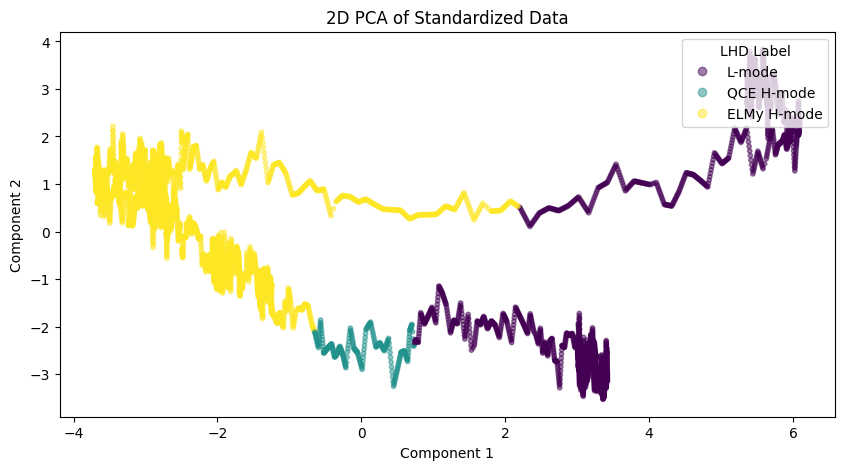

In [16]:
draw_reduced_space(X_pca[:, :2], y, n_components = 2, title = "2D PCA of Standardized Data")

# How about 3D

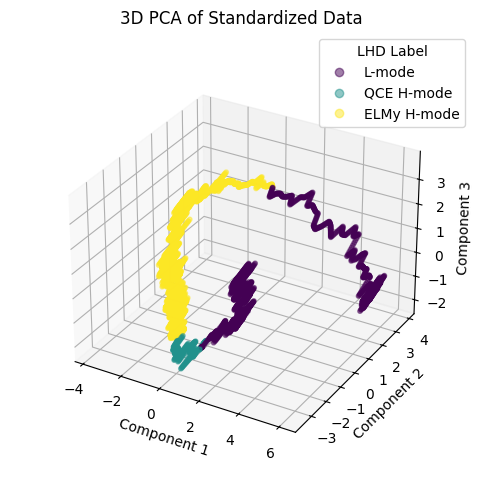

In [17]:
draw_reduced_space(X_pca[:, :3], y, n_components = 3, title = "3D PCA of Standardized Data")

# Analysis
Looking at the PCA for a single shot, we can see that the scatter plots follow a somewhat continuous path. As such we can expect Clustering Algorithms like DBSCAN to perform better than for instance K-means (which favor clusters that are spherical and not complex shapes of dense neighborhoods of points)

When considering 5 shots, we can already see that the scatter plots start overlapping; however, there are two clearly distinct clusters appearing. The initial hypothesis is that this change comes from the is_baffled state; however, this will need to be checked.

# Clustering

## DBSCAN

# Generate a range of values for eps and min_samples

Hyperparameter tuning is essential

We need to choose the MinPts (the min number of points per cluster), and eps the radius for neighborhood computation.

MinPts: 
In practice, a general rule of thumb is that the min cluster size is equal to 2 * #features; however it can be higher for noisy data.

eps:
The value for epsilon can be chosen using a k-distance graph, which consists in plotting the distance to the k = minPts-1 nearest neighbors (ordered)
Good values of ε are where this plot shows an "elbow"

In [18]:
num_features = X.shape[1]
eps_values = np.linspace(0.1, 4.0, 10) #DBSCAN takes much more time for higher eps
min_pts = 2 * X.shape[1]#range(40,100,20)

In [19]:
# Initialize variables to store results
best_eps = None
best_silhouette_score = -1  # Initialize with a value less than any possible silhouette score

# Initialize matrix to store silhouette scores
silhouette_scores = np.zeros((len(eps_values)))

Computing the silhouette score is quite expensive as it involves the computation of the euclidean distance between all pairs in X. (~360 min)

A possible solution is to only compute this matrix once; however, if X has N samples then the distance matrix has N^2 samples which is too large for N >= 50 000

Since we have 60 shots, taking half of them is representative enough for our dataset and reduces overfitting. (would take ~90 min)

Also note that DBSCAN time complexity increases very quickly as eps increases.

In [20]:
# X is already standardized.
X_standardized = X

In [ ]:
plt.plot(np.array([2]), silhouette, "ro")
plt.title("DBSCAN Hyperparameter Tuning")
plt.xlabel("Epsilon (eps)")
plt.ylabel("Silhouette Score")

In [ ]:
dbscan = DBSCAN()
# Loop over different combinations of eps and min_samples
for i, (eps, min_pts) in tqdm(enumerate(parameters_ranges)):
    # Fit DBSCAN with current parameters
    start = datetime.now()
    dbscan = 0 dbscan.set_params(eps=eps, min_samples=min_pts)# DBSCAN(eps=eps, min_samples=min_pts)
    labels = dbscan.fit_predict(X_standardized)
    print("DBSCAN ", datetime.now()-start)
    
    # Calculate silhouette score
    start = datetime.now()
    try:
        silhouette = 0 # silhouette_score(X_standardized, labels)
    except:
        silhouette = 0
    print("Silhouette ", datetime.now()-start)
    silhouette_scores[i // len(eps_values),i % len(min_pts_values)] = silhouette  
    # Store the silhouette score
        
    # Update the best parameters if the silhouette score is higher
    if silhouette > best_silhouette_score:
        best_silhouette_score = silhouette
        best_min_pts = min_pts
        best_eps = eps

# Print the best parameters
print(f"Best eps: {best_eps}")
print(f"Best min_pts: {best_min_pts}")
print(f"Best silhouette score: {best_silhouette_score}")

In [ ]:
plt_x, plt_y = np.meshgrid(eps_values, min_pts_values)
plt_x = plt_x.flatten()
plt_y = plt_y.flatten()
silhouette_scores_flat = silhouette_scores.flatten()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(plt_x, plt_y, silhouette_scores_flat, c=silhouette_scores_flat, cmap='viridis', s=10, alpha=0.5)
ax.set_xlabel("Epsilon (eps)")
ax.set_ylabel('Minimum Point number (min_pts)')
ax.set_zlabel("Silhouette Score")
ax.set_title("DBSCAN Hyperparameter Tuning")
ax.set_box_aspect(aspect=None, zoom=0.85)

Ideally, we want an epsilon that yields the highest silhouette score; however, we want epsilon to be small too. So here we take the smallest epsilon which yields a high silhouette score.

In [ ]:
selected_eps = 0.02957 # best_eps #2 #0.5
selected_min_pts = num_features #best_min_pts
dbscan = DBSCAN(eps=selected_eps, min_samples=selected_min_pts).fit(X)

labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

In [ ]:
draw_reduced_space(X_pca[:, :3], labels, n_components = 3, legend_labels = [0,1,2], legend_title ="Clusters", title = "DBSCAN Clusters: Visualized with 3D PCA")

As a first visualisation, DBscan only manages to differenciate non-similar shots, however, upon closer inspection it achieves to regroup some of them that have high correlation on their components.

This separation could allow us to regroup similar shots for further and closer inspection.